In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer


In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [3]:
random_seed = 2512
random_state = np.random.RandomState(random_seed)

# Loading and preparing data

In [4]:
OUTCOMES = ['Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp',]
AMBIGUOUS_COLUMNS = ['PRU_more208', 'PRU_less95']
STRING_COLUMNS = ['AF_type', 'Stent_type', 'CYP4F2', 'P2Y12']
MAX_PRU = 208 # Maximum and minimum PRU borders, lower and higher is an unsafe zone
MIN_PRU = 95


In [5]:
df = pd.read_csv('xarelto_fg.csv', header=0, index_col=0)[:103]
# df = df.replace(' ', np.nan)
for outcome in OUTCOMES:
    df[outcome] = df[outcome].replace(' ', 0).astype(float)

for category_col in STRING_COLUMNS:
    encoder = LabelEncoder()
    print(category_col)
    df[category_col + '_encoded'] = encoder.fit_transform(df[category_col])

SINGLE_VALUE_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 1]

AF_type
Stent_type
CYP4F2
P2Y12


# Initial analysis

In [6]:
SINGLE_VALUE_COLUMNS

['Thrombosysis', 'CYP2C19_3_G636A']

In [7]:
df.Thrombosysis.describe()

count     103
unique      1
top         0
freq      103
Name: Thrombosysis, dtype: object

In [8]:
df.head()

,Sex,Age,Xarelto_C_blood,Agr_Platelets_base,inhibition,PRU,PRU_more208,PRU_less95,C_rivar_137,Agr_Platelets_Cat,...,CES1,CYP3A4_2242480,PON1,IGTB3,P2Y12,PEAR1_rs41273215,AF_type_encoded,Stent_type_encoded,CYP4F2_encoded,P2Y12_encoded
Number,,,,,,,,,,,,,,,,,,,,,
1,1,81,204,195,48,102,2,2,1,2,...,1,1,2,1,1,1,2,2,2,1
2,1,88,134,196,28,141,2,2,0,2,...,1,1,2,2,1,1,2,0,1,1
3,1,81,242,211,13,183,2,2,1,3,...,2,1,2,1,2,2,2,3,2,2
4,0,73,57,163,12,144,2,2,0,2,...,2,1,2,2,2,2,1,3,2,2
5,0,61,37,182,11,162,2,2,0,2,...,1,1,2,1,2,1,1,3,2,2


In [9]:
df.columns

Index(['Sex', 'Age', 'Xarelto_C_blood', 'Agr_Platelets_base', 'inhibition',
       'PRU', 'PRU_more208', 'PRU_less95', 'C_rivar_137', 'Agr_Platelets_Cat',
       'Residual_more230', 'Residual_reactivity_less85', 'STEMI', 'NSTEMI',
       'Unstableangina', 'PCI', 'AF_type', 'Death_inhosp', 'Obesity',
       'Alcohol', 'Smoking', 'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG',
       'Thrombosysis', 'Access', 'Stent_type', 'Stent_quant', 'HighriskSYNTAX',
       'Grace_score_risk', 'SYNTAX_score', 'CRUSADE', 'Killip',
       'CrusadeScore_bleeding', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Acatalepsia', 'Gastric', 'Previous_bleeding',
       'Anaemialessthan100', 'Plateletslessthan100',
       'Highplateletsondischarge', 'Death_and_renal_failure', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dos

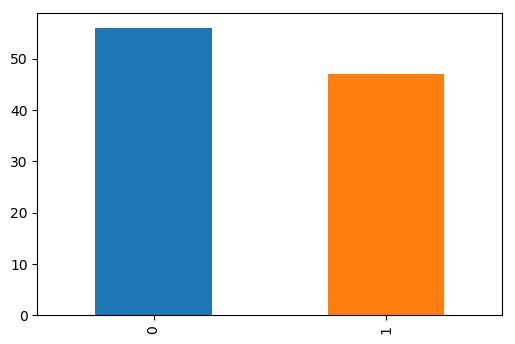

In [10]:
df.Sex.value_counts().plot(kind='bar')

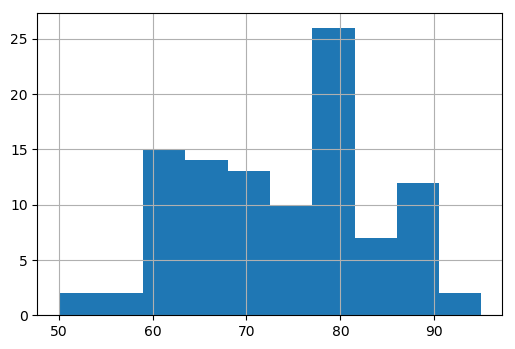

In [11]:
df.Age.astype(float).hist()

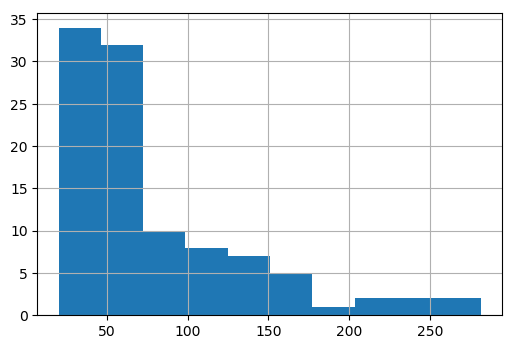

In [12]:
df.Xarelto_C_blood.astype(float).hist()

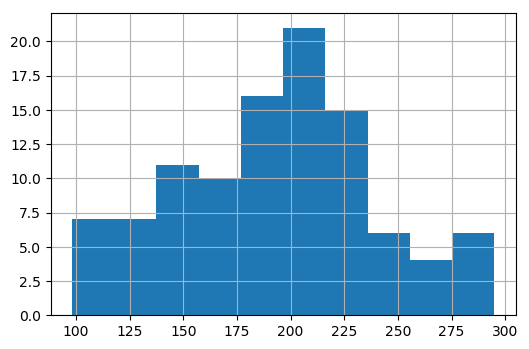

In [13]:
df.Agr_Platelets_base.astype(float).hist()

# Task number 1

Concentration prediction

Target columns -> `'Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp'`

## Analysing and converting boolean outcome variables into single categorical ones

In [14]:
df[[col for col in df.columns if col in OUTCOMES]].describe()

,Death_inhosp,Death_and_renal_failure,Significant_bleeding_outcome,Stroke_outcome
count,103.000000,103.000000,103.000000,103.000000
mean,0.029126,0.320388,0.106796,0.019417
std,0.168983,0.468908,0.310364,0.138662
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


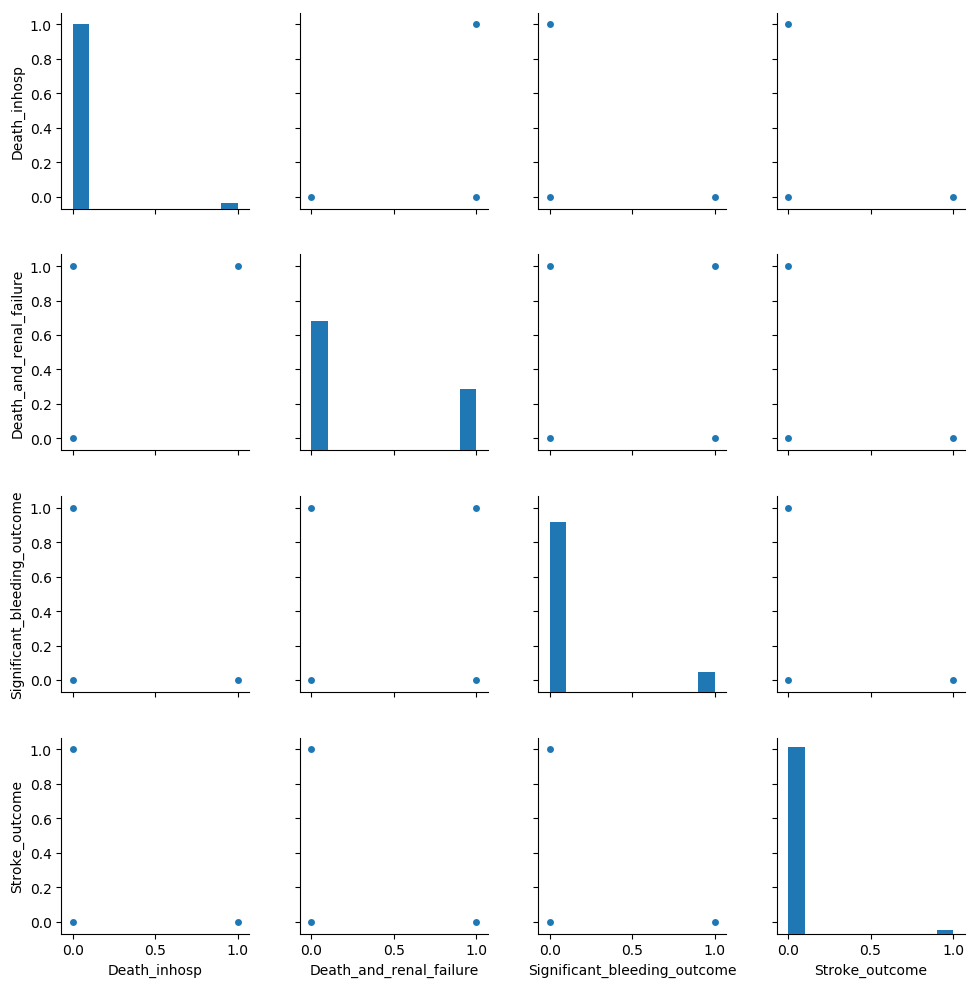

In [15]:
sns.pairplot(df[[col for col in df.columns if col in OUTCOMES]].astype('int'))

In [16]:
df1 = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *SINGLE_VALUE_COLUMNS,
            *AMBIGUOUS_COLUMNS,
            *STRING_COLUMNS,
        ]
    ]
]
df1 = df1.replace(' ', 0)

In [17]:
def _process_row_outcomes(row):
    possible_outcomes = [outcome for outcome in OUTCOMES if row[outcome]]
    if not possible_outcomes:
        return 'Survived'
    elif len(possible_outcomes) == 1:
        return possible_outcomes[0]
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_and_renal_failure' in possible_outcomes
    ):
        return 'Death_renal_failure_bleeding' # TODO, Ask Karin whether we should consider this outcome
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_inhosp' in possible_outcomes
    ):
        return 'Death_in_hospital_bleeding' # TODO, Ask Karin whether we should consider this outcome
    else:
        return 'Death_renal_failure_inhosp'


def process_row_outcomes(row):
    outcome = _process_row_outcomes(row)
    if 'Death' in outcome: # TODO Discuss with Karin
        return 'Death'
    elif (
        outcome == 'Significant_bleeding_outcome' or 
        outcome == 'Stroke_outcome'
    ):
#         return 'Bleeding_or_stroke'
        return 'Survived'
    return outcome

df1['Outcome'] = df.apply(
    process_row_outcomes,
    axis = 1
)

In [18]:
df1['Outcome'].describe()

count          103
unique           2
top       Survived
freq            70
Name: Outcome, dtype: object

In [19]:
df1['Outcome'].unique()

array(['Death', 'Survived'], dtype=object)

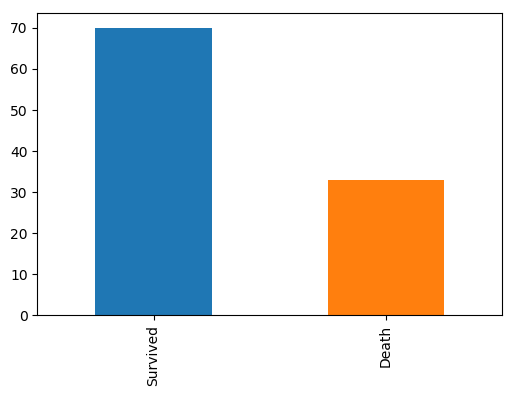

In [20]:
df1.Outcome.value_counts().plot(kind='bar')

In [21]:
df1.columns

Index(['Sex', 'Age', 'Xarelto_C_blood', 'Agr_Platelets_base', 'inhibition',
       'PRU', 'C_rivar_137', 'Agr_Platelets_Cat', 'Residual_more230',
       'Residual_reactivity_less85', 'STEMI', 'NSTEMI', 'Unstableangina',
       'PCI', 'Obesity', 'Alcohol', 'Smoking', 'Cardiosclerosis',
       'Previous_PCI', 'PreviousCABG', 'Access', 'Stent_quant',
       'HighriskSYNTAX', 'Grace_score_risk', 'SYNTAX_score', 'CRUSADE',
       'Killip', 'CrusadeScore_bleeding', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Acatalepsia', 'Gastric', 'Previous_bleeding',
       'Anaemialessthan100', 'Plateletslessthan100',
       'Highplateletsondischarge', 'RenalFailure', 'HeartFailure', 'HasBLED39',
       'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC', 'Hasbled', 'duration_months',
       'Rivaroxaban_dose', 'CYP3A4_22', 'ABCB1_С3435Т', 'ABCB1_СТrs4148738',
       'CYP2C19_2_G681A', 'CYP2C19_17_C806T', 'CYP3A5_3_A6986G',
 

In [22]:
encoder = LabelEncoder()
df1.Outcome = encoder.fit_transform(df1.Outcome)

## Building models

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    roc_curve,
    auc, accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.multiclass import OneVsRestClassifier

In [24]:
X = df1[[col for col in df1.columns if col != 'Outcome']]
Y = df1.Outcome

## Binary Model evaluation

In [37]:
def evaluate_binary(model, X, Y):

    ##### ROC plot - AUC calculation

    folded_data = KFold(n_splits=5, random_state=random_seed, shuffle=True)
    tprs = []
    aucs, acc, rec, prec = [], [], [], []

    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    plt.figure(figsize=(10,7))
    for k, (train, test) in enumerate(folded_data.split(X, Y)):
        probas_ = model.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        Y_pred = rf.predict(X.iloc[test])
        acc.append(accuracy_score(Y.iloc[test], Y_pred))
        prec.append(precision_score(Y.iloc[test], Y_pred))
        rec.append(recall_score(Y.iloc[test], Y_pred))
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
        )

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8
    )
    fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color='grey',
        alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for transposon recognition')
    plt.legend(loc="lower right")
    plt.show()
    
    ##### Precision-recall plot

    precisions = []

    best_precision = {"precision_score": 0.0, "precision": None, "recall": None}

    for k, (train, test) in enumerate(folded_data.split(X, Y)):
        probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(Y.iloc[test], probas_[:, 1])
        average_precision = average_precision_score(Y.iloc[test], probas_[:, 1])
        if average_precision > best_precision["precision_score"]:
            best_precision["precision"] = precision
            best_precision["recall"] = recall
            best_precision["precision_score"] = average_precision
        precisions.append(average_precision)
        plt.step(
            recall,
            precision,
            alpha=0.5,
            where='post',
            label='Precision-recall fold {0:0.4f}'.format(average_precision)
        )
    average_precision = sum(precisions)/len(precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.legend(loc="lower right")
    plt.show()


In [38]:
def plot_important_features(X, coefficients):
    ##### TOP MOST IMPORTANT FEATURES PLOT

    N_to_print = 10
    y_pos = range(N_to_print)
    fig, ax = plt.subplots()
    plt.figure(figsize=(10,7))

    feature_importance = coefficients.round(4)
    feature_importance = zip(X.keys(), feature_importance)
    feature_importance = np.array(sorted(feature_importance, key=lambda x:x[1], reverse=True))

    ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
    ax.set_yticks(np.arange(N_to_print))
    ax.set_yticklabels(feature_importance[:N_to_print, 0])
    ax.invert_yaxis()
    ax.set_xlabel('Importance score')

    plt.show()

### 1. Random Forest Classifier

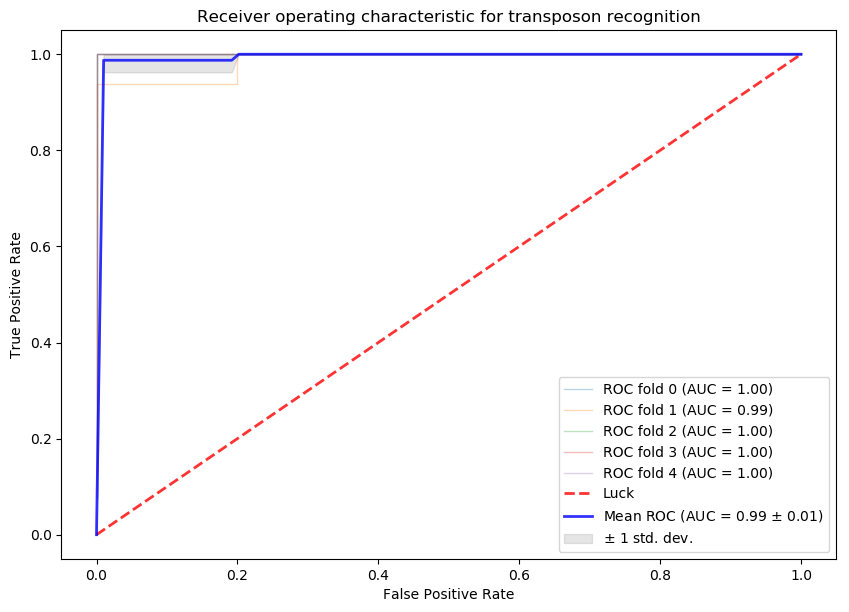

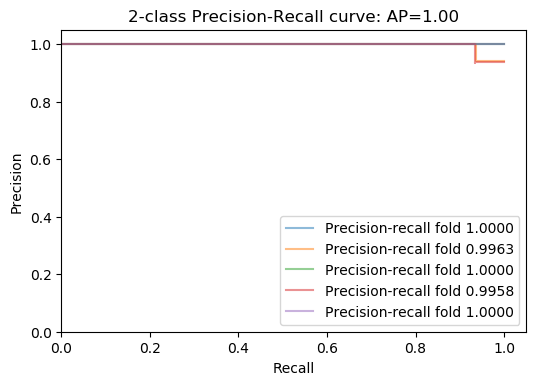

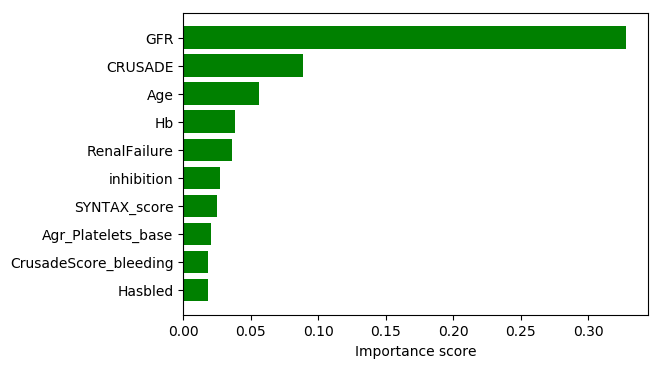

<Figure size 1000x700 with 0 Axes>

In [39]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
evaluate_binary(rf, X, Y)
# Learn to predict each class against the other
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                  random_state=random_state))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)
plot_important_features(X, rf.feature_importances_)

In [45]:
len(rf.feature_importances_)

72

### 2. SVM - SVC

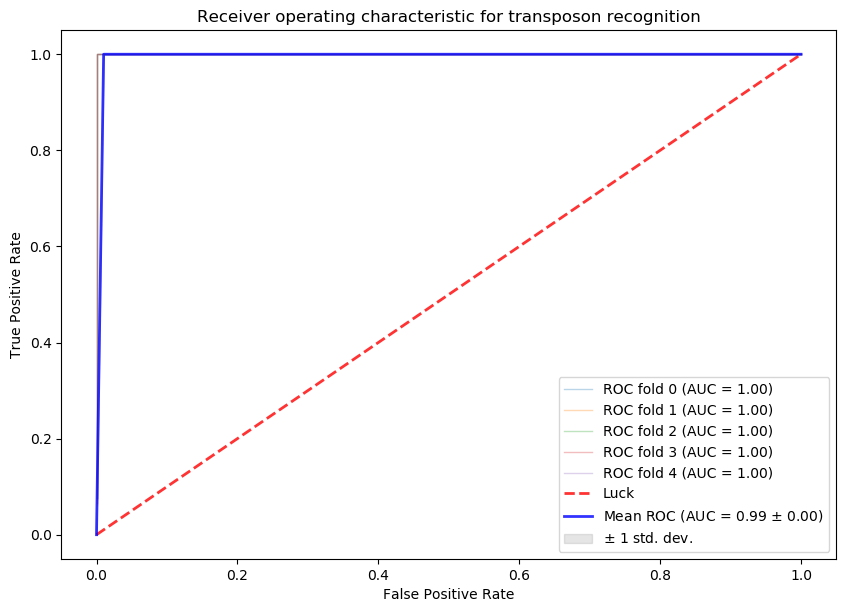

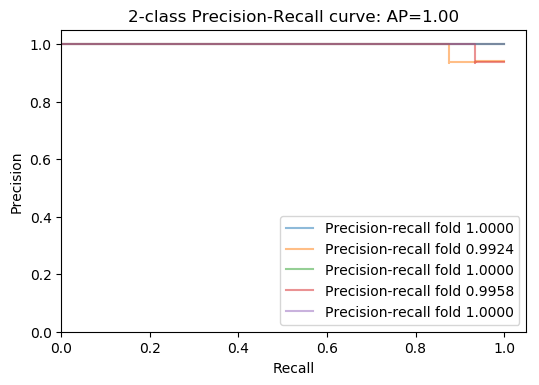

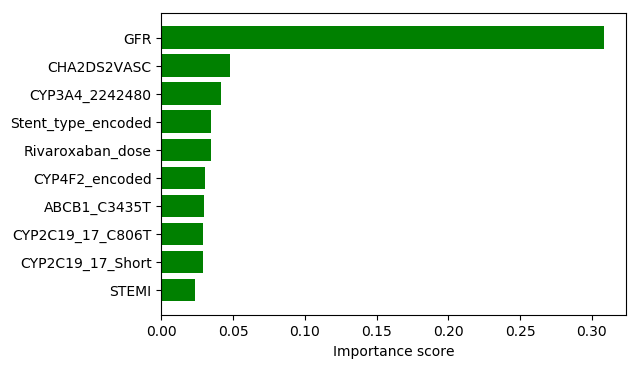

<Figure size 1000x700 with 0 Axes>

In [50]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', probability=True, random_state=random_state)
evaluate_binary(svc, X, Y)

plot_important_features(X, svc.coef_[0])



# Task number 2

Concentration prediction

Target column -> `Xarelto_C_blood`

### Removing outcome columns 

In [28]:
df1 = df[[col for col in df.columns if not col in ['Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp',]]]





In [29]:
len(df1.columns)

80

In [30]:
len(df.columns)

84